### Классификация по тональности
В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru.

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5.

Тексты хранятся в json-ах в массиве responses.

Посмотрим на примере отзыва: возьмите для удобства ноутбук, размещенный в папке репозитория.


### Часть 1. Анализ текстов
1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах
3. Найдите 10 самых частых:
- слов
- слов без стоп-слов
- лемм
- существительных

4. Постройте кривые Ципфа и Хипса
5. Ответьте на следующие вопросы:
- какое слово встречается чаще, "сотрудник" или "клиент"?
- сколько раз встречается слова "мошенничество" и "доверие"?

6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

### Часть 2. Тематическое моделирование
1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?
Эта часть задания может быть сделана с использованием gensim.

### Часть 3. Классификация текстов
Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5).

1. Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам.
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
- 1-ый вариант: $tf-idf$ преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
- 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).
Используйте accuracy и F-measure для оценки качества классификации.

В ноутбуке, размещенном в папке репозитория. написан примерный Pipeline для классификации текстов.

Эта часть задания может быть сделана с использованием sklearn.

In [ ]:
import json

import re
from tqdm import tqdm
from scipy import sparse

In [ ]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
!pip install wordcloud
from wordcloud import WordCloud
nltk.download('stopwords')

from nltk.corpus import stopwords

!pip install pymystem3

from pymystem3 import Mystem

!pip install pymorphy2
from pymorphy2 import MorphAnalyzer


%matplotlib inline
%pylab inline

Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Анастасия\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable


Populating the interactive namespace from numpy and matplotlib


In [ ]:
import math
import matplotlib.pyplot as plt
import collections

!pip install gensim
import gensim
import gensim.corpora as corpora

!pip install pyldavis
import pyLDAvis
import pyLDAvis.gensim

Defaulting to user installation because normal site-packages is not writeable


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 2.6/2.6 MB 66.6 kB/s eta 0:00:00
   --------------------------------------- 301.8/301.8 kB 56.9 kB/s eta 0:00:00
   ---------------------------------------- 11.6/11.6 MB 114.7 kB/s eta 0:00:00
   -------------------------------------- 346.6/346.6 kB 148.4 kB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import train_test_split

from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
responses = []
with open ('banki_responses.json', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [00:18, 11074.31it/s]



Посмотрим на пример отзыва:

In [ ]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

In [ ]:
df = pd.DataFrame(responses)

In [ ]:
df.head()

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [ ]:
len(df.city.unique())

5824

In [ ]:
df.groupby("city")["text"].count()

city
г.  (Красногорск)                           1
г.  (Москва)                                2
г.  (Россия)                                1
г.  (Ханты-Мансийский автономный округ)     1
г. -                                        1
                                           ..
г. ялуторовск                               1
г. янаул                                    2
г. ярославль                               12
г. ярцево                                   2
г. … или другой населенный пункт            1
Name: text, Length: 5823, dtype: int64

In [ ]:
def clean_city(s):
    if s is not None:
        s = s.lower()
        s = s.replace("г.", "")
        s = re.sub(r"[^а-яё\-\s]"," ", s)
        s = re.sub(r"\s+", " ", s)
        return s
    else:
        pass


In [ ]:
df["city"] = df["city"].apply(clean_city)

In [ ]:
df.groupby("city")["text"].count().sort_values(ascending = False)[:10]

city
 москва             56780
 санкт-петербург    14657
 новосибирск         2382
 екатеринбург        2376
 нижний новгород     2037
 ростов-на-дону      1939
 самара              1785
 челябинск           1541
 казань              1516
 уфа                 1321
Name: text, dtype: int64

In [ ]:
df.groupby("bank_name")["text"].count().sort_values(ascending = False)[:50]

bank_name
Сбербанк России                                         26327
Альфа-Банк                                              10224
ВТБ 24                                                   8185
Русский Стандарт                                         7943
Хоум Кредит Банк                                         7549
Тинькофф Банк                                            5387
Национальный Банк «Траст»                                4607
Ренессанс Кредит                                         3849
Связной Банк                                             3775
ОТП Банк                                                 3237
Восточный Экспресс Банк                                  3138
Райффайзенбанк                                           3057
Московский Кредитный Банк                                2944
Ситибанк                                                 2848
Авангард                                                 2733
Промсвязьбанк                                            258

In [ ]:
pd.pivot_table(df, values = "text", index = ["city", "bank_name"], aggfunc = "count").sort_values("text", ascending = False)

text
city             bank_name               
 москва          Сбербанк России     8341
                 Альфа-Банк          3972
                 Русский Стандарт    2905
                 ВТБ 24              2758
 санкт-петербург Сбербанк России     2493
...                                   ...
 миасс           Киви Банк              1
                 Кредит Европа Банк     1
                 Промсвязьбанк          1
                 Райффайзенбанк         1
 ёсаратов        Ренессанс Кредит       1

[16794 rows x 1 columns]

In [ ]:
df["lenchartext"] = df.text.apply(lambda s: len(s))

In [ ]:
df["lenchartext"].describe()

count    153499.000000
mean       1554.212790
std        1319.098042
min          23.000000
25%         732.000000
50%        1193.000000
75%        1929.000000
max       32082.000000
Name: lenchartext, dtype: float64

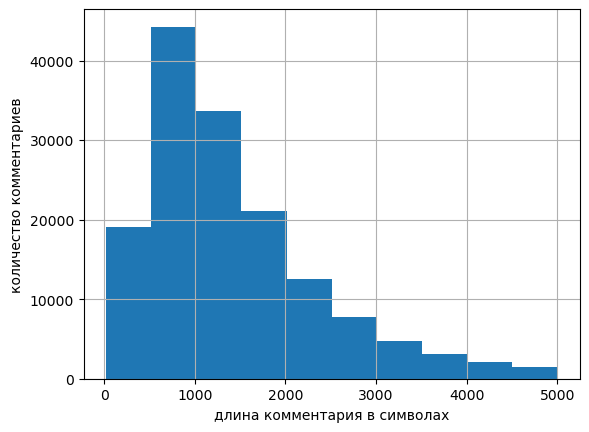

In [ ]:
df["lenchartext"][df["lenchartext"] < 5000].hist()
plt.xlabel("длина комментария в символах")
plt.ylabel("количество комментариев");

In [ ]:
df["lenwordtext"] = df.text.apply(lambda s: len(s.split()))

In [ ]:
df["lenwordtext"].describe()

count    153499.000000
mean        237.062743
std         201.430014
min           1.000000
25%         111.000000
50%         182.000000
75%         295.000000
max        5000.000000
Name: lenwordtext, dtype: float64

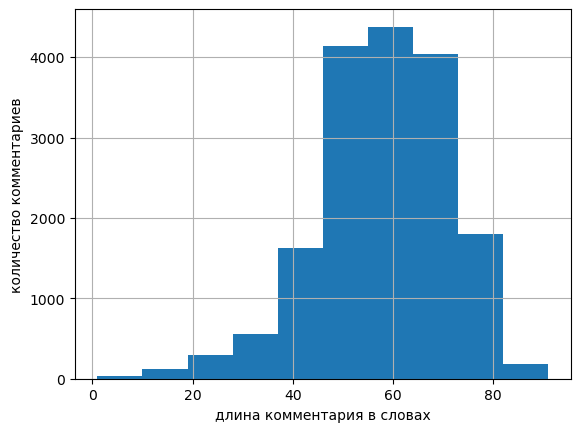

In [ ]:
df["lenwordtext"][df["lenchartext"] < 500].hist()
plt.xlabel("длина комментария в словах")
plt.ylabel("количество комментариев");

In [ ]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\sa-zA-Zа-яА-ЯёЁ0-9\-]', ' ', text)
    text = re.sub(r'\w*\d+\w*', " ", text)
    text = re.sub(r'\s{2,}', " ", text)
    return text

In [ ]:
df["clean_text"] = df["text"].apply(clean_text)

In [ ]:
df["clean_text"][:50]

0     добрый день я не являюсь клиентом банка и пору...
1     доброго дня являюсь держателем зарплатной карт...
2     здравствуйте дублирую свое заявление от в до м...
3     добрый день я открыл расчетный счет в сбербанк...
4      г взяла кредит в вашем банке заявленная мною ...
5     я как и многие вкладчики открыл на руб со счас...
6     здравствуйте подал заявление на получение уэк ...
7     был крайне удивлён новостью от мая - об унифик...
8     сотрудники банка восточный систематически сооб...
9     добрый день являюсь заемщиком в банке втб боле...
10    вот даже и засомневалась какую ставить оценку ...
11    добрый день ещё апреля года я пыталась сделать...
12    разбавлю негативные отзывы ложкой меда благода...
13    без оценки т к несколько лет отличной работы и...
14    также как и многие давний клиент банка был дов...
15     - - были произведены платежа через банкомат в...
16    здравствуйте уважаемый совкомбанк моя знакомая...
17    хочется высказать по поводу режима работы 

In [ ]:
dictionary_ = Counter(df["clean_text"].str.split().explode())

In [ ]:
dictionary_.most_common(10)

[('в', 1327451),
 ('и', 1057827),
 ('не', 852019),
 ('на', 704577),
 ('что', 621899),
 ('я', 576013),
 ('с', 460067),
 ('-', 372835),
 ('по', 365282),
 ('мне', 320752)]

In [ ]:
stop_words = stopwords.words("russian")

In [ ]:
stop_words

['и',
 'в',
 'во',
 'не',
 'что',
 'он',
 'на',
 'я',
 'с',
 'со',
 'как',
 'а',
 'то',
 'все',
 'она',
 'так',
 'его',
 'но',
 'да',
 'ты',
 'к',
 'у',
 'же',
 'вы',
 'за',
 'бы',
 'по',
 'только',
 'ее',
 'мне',
 'было',
 'вот',
 'от',
 'меня',
 'еще',
 'нет',
 'о',
 'из',
 'ему',
 'теперь',
 'когда',
 'даже',
 'ну',
 'вдруг',
 'ли',
 'если',
 'уже',
 'или',
 'ни',
 'быть',
 'был',
 'него',
 'до',
 'вас',
 'нибудь',
 'опять',
 'уж',
 'вам',
 'ведь',
 'там',
 'потом',
 'себя',
 'ничего',
 'ей',
 'может',
 'они',
 'тут',
 'где',
 'есть',
 'надо',
 'ней',
 'для',
 'мы',
 'тебя',
 'их',
 'чем',
 'была',
 'сам',
 'чтоб',
 'без',
 'будто',
 'чего',
 'раз',
 'тоже',
 'себе',
 'под',
 'будет',
 'ж',
 'тогда',
 'кто',
 'этот',
 'того',
 'потому',
 'этого',
 'какой',
 'совсем',
 'ним',
 'здесь',
 'этом',
 'один',
 'почти',
 'мой',
 'тем',
 'чтобы',
 'нее',
 'сейчас',
 'были',
 'куда',
 'зачем',
 'всех',
 'никогда',
 'можно',
 'при',
 'наконец',
 'два',
 'об',
 'другой',
 'хоть',
 'после',
 'на

In [ ]:
stop_words_set = set(stop_words + ["-", "это"])

In [ ]:
df["clean_text_without_stops"] = df["clean_text"].apply(lambda s: " ".join([word for word in s.split() if word not in stop_words_set]))

In [ ]:
df

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,lenchartext,lenwordtext,clean_text,clean_text_without_stops
0,москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,1523,219,добрый день я не являюсь клиентом банка и пору...,добрый день являюсь клиентом банка поручителем...
1,новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,1026,140,доброго дня являюсь держателем зарплатной карт...,доброго дня являюсь держателем зарплатной карт...
2,москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,588,90,здравствуйте дублирую свое заявление от в до м...,здравствуйте дублирую свое заявление можайский...
3,ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN,740,123,добрый день я открыл расчетный счет в сбербанк...,добрый день открыл расчетный счет сбербанке юр...
4,челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN,1896,306,г взяла кредит в вашем банке заявленная мною ...,г взяла кредит вашем банке заявленная мною сум...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153494,None,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0,353,52,слишком большой банк не всегда учитывает нашу ...,слишком большой банк учитывает нашу специфику ...
153495,None,False,А вы договор читали?,0,лицензия № 2557,Kirill,Ситибанк,2005-04-14 15:25:00,"Вы сами виноваты в своих проблемах, кроме пред...",3.0,727,111,вы сами виноваты в своих проблемах кроме предп...,сами виноваты своих проблемах кроме предпослед...
153496,None,False,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0,5388,764,уважаемое руководство банка овк я проживаю в г...,уважаемое руководство банка овк проживаю г ива...
153497,None,False,В Альфа-Банк больше обращаться не буду.,0,лицензия № 1326,Ирина,Альфа-Банк,2005-04-14 15:16:00,Пробовала 10.04.05 оформить товар в кредит в А...,1.0,692,104,пробовала оформить товар в кредит в альфа-банк...,пробовала оформить товар кредит альфа-банке ко...


In [ ]:
dictionary_stop = Counter(df["clean_text_without_stops"].str.split().explode())

In [ ]:
dictionary_stop.most_common(10)

[('банка', 264263),
 ('банк', 196589),
 ('деньги', 130501),
 ('карту', 105175),
 ('карты', 101247),
 ('кредит', 80465),
 ('день', 76268),
 ('т', 72980),
 ('заявление', 69626),
 ('отделение', 66540)]

In [ ]:
'''mystem = Mystem()
df["text_lemma"] = df['clean_text_without_stops'].apply(lambda s: " ".join(mystem.lemmatize(s)))'''

In [ ]:
'''df'''

In [ ]:
morph = MorphAnalyzer()
df["text_lemma"] = df['clean_text_without_stops'].apply(lambda s: " ".join([morph.normal_forms(token)[0] for token in s.split()]))

In [ ]:
df

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,lenchartext,lenwordtext,clean_text,clean_text_without_stops,text_lemma
0,москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,1523,219,добрый день я не являюсь клиентом банка и пору...,добрый день являюсь клиентом банка поручителем...,добрый день являться клиент банк поручитель кр...
1,новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,1026,140,доброго дня являюсь держателем зарплатной карт...,доброго дня являюсь держателем зарплатной карт...,добрый день являться держатель зарплатный карт...
2,москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,588,90,здравствуйте дублирую свое заявление от в до м...,здравствуйте дублирую свое заявление можайский...,здравствуйте дублировать свой заявление можайс...
3,ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN,740,123,добрый день я открыл расчетный счет в сбербанк...,добрый день открыл расчетный счет сбербанке юр...,добрый день открыть расчётный счёт сбербанк юр...
4,челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN,1896,306,г взяла кредит в вашем банке заявленная мною ...,г взяла кредит вашем банке заявленная мною сум...,г взять кредит ваш банк заявить я сумма так ру...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153494,None,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0,353,52,слишком большой банк не всегда учитывает нашу ...,слишком большой банк учитывает нашу специфику ...,слишком большой банк учитывать наш специфика п...
153495,None,False,А вы договор читали?,0,лицензия № 2557,Kirill,Ситибанк,2005-04-14 15:25:00,"Вы сами виноваты в своих проблемах, кроме пред...",3.0,727,111,вы сами виноваты в своих проблемах кроме предп...,сами виноваты своих проблемах кроме предпослед...,сам виноватый свой проблема кроме предпоследни...
153496,None,False,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0,5388,764,уважаемое руководство банка овк я проживаю в г...,уважаемое руководство банка овк проживаю г ива...,уважаемый руководство банк овк проживать г ива...
153497,None,False,В Альфа-Банк больше обращаться не буду.,0,лицензия № 1326,Ирина,Альфа-Банк,2005-04-14 15:16:00,Пробовала 10.04.05 оформить товар в кредит в А...,1.0,692,104,пробовала оформить товар в кредит в альфа-банк...,пробовала оформить товар кредит альфа-банке ко...,пробовать оформить товар кредит альфа-банк ком...


In [ ]:
dictionary_lemma = Counter(df["text_lemma"].str.split().explode())

In [ ]:
dictionary_lemma.most_common(10)

[('банк', 627200),
 ('карта', 332871),
 ('деньга', 178962),
 ('день', 173205),
 ('мой', 167071),
 ('кредит', 155265),
 ('который', 148998),
 ('отделение', 143828),
 ('счёт', 141503),
 ('сотрудник', 133780)]

In [ ]:
def noun(s):
    new_s = []
    for word in s.split():
        analize = morph.parse(word)
        if analize[0].tag.POS == "NOUN":
            new_s.append(analize[0].normal_form)
    return " ".join(new_s)

In [ ]:
df["text_noun"] = df["text_lemma"].apply(noun)

In [ ]:
df.to_csv("bank_lemma.csv")

In [ ]:
dictionary_noun = Counter(df["text_noun"].str.split().explode())

In [ ]:
dictionary_noun.most_common(10)

[('банк', 627225),
 ('карта', 332872),
 ('деньга', 178962),
 ('день', 173205),
 ('кредит', 155265),
 ('отделение', 143828),
 ('счёт', 141503),
 ('сотрудник', 133780),
 ('клиент', 133122),
 ('сумма', 111037)]

In [ ]:
def build_zipf_curve(words):
    """Строит кривую Ципфа для заданного текста."""
    word_counts = collections.Counter(words)
    sorted_words = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)
    ranks = range(1, len(sorted_words) + 1)
    frequencies = [item[1] for item in sorted_words]
    plt.figure(figsize=(10, 6))
    plt.loglog(ranks, frequencies, marker='o', linestyle='-', label='Кривая Ципфа')
    plt.xlabel("Ранг слова")
    plt.ylabel("Частота слова")
    plt.title("Кривая Ципфа для текста")
    plt.legend()
    plt.show()

In [ ]:
def build_heap_curve(words):
    """Строит кривую Хипса для заданного текста."""
    unique_words = set(words)
    n_unique_words = len(unique_words)
    word_counts = collections.Counter(words)
    sorted_words = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)
    cumulative_frequencies = [0]
    for _, frequency in sorted_words:
        cumulative_frequencies.append(cumulative_frequencies[-1] + frequency)
    n_words = len(words)
    x_values = [math.log(i / n_words) for i in range(1, n_unique_words + 1)]
    y_values = [math.log(i / n_unique_words) for i in cumulative_frequencies[1:]]
    plt.figure(figsize=(10, 6))
    plt.plot(x_values, y_values, marker='o', linestyle='-', label='Кривая Хипса')
    plt.xlabel("Log(i/N)")
    plt.ylabel("Log(i/V)")
    plt.title("Кривая Хипса для текста")
    plt.legend()
    plt.show()

In [ ]:
words = list(df["text_lemma"].str.split().explode())

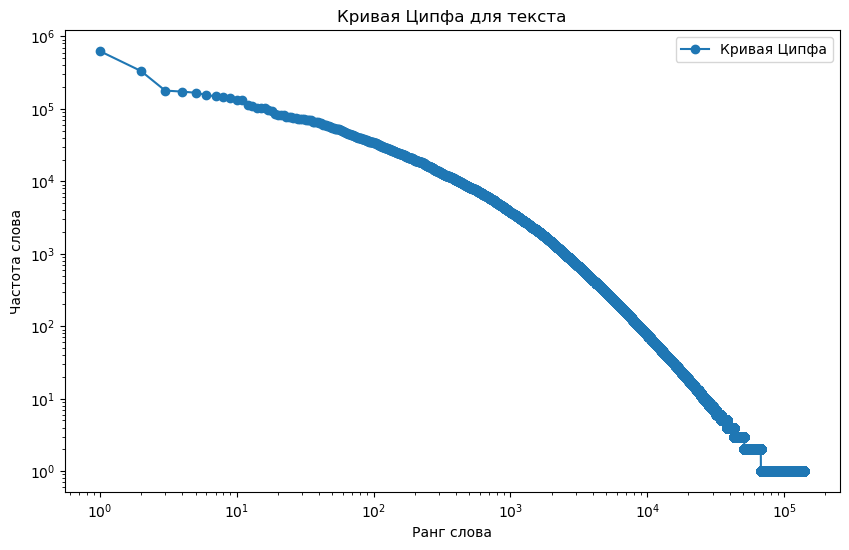

In [ ]:
build_zipf_curve(words)

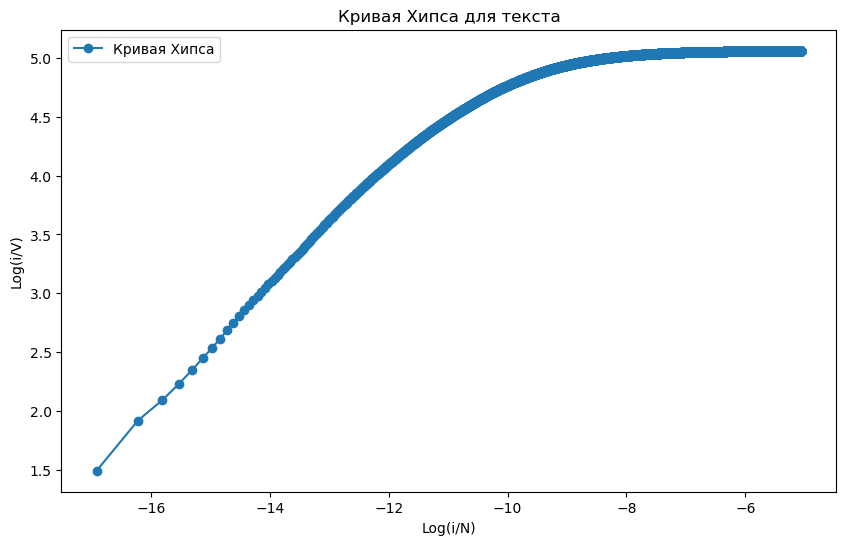

In [ ]:
build_heap_curve(words)

In [ ]:
a = dictionary_noun["клиент"]
b = dictionary_noun["сотрудник"]

In [ ]:
a, b

(133122, 133780)

In [ ]:
if a > b:
    print("клиент встречается чаще, чем сотрудник")
else:
    print("сотрудник встречается чаще, чем клиент")

сотрудник встречается чаще, чем клиент


In [ ]:
c = dictionary_noun["мошеничество"]
d = dictionary_noun["доверие"]

In [ ]:
c, d

(21, 2105)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf = TfidfVectorizer(ngram_range = (1, 2))
X_train_tfidf = tfidf.fit_transform(df["text_lemma"])
X_train_tfidf

<153499x4680906 sparse matrix of type '<class 'numpy.float64'>'
	with 36893428 stored elements in Compressed Sparse Row format>

In [ ]:
df_1 = df[df["rating_grade"] == 1]
df_1

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,lenchartext,lenwordtext,clean_text,clean_text_without_stops,text_lemma,text_noun
19,москва,False,Некомпетентность сотрудников банка,2,лицензия № 1481,agelun,Сбербанк России,2015-06-05 15:00:54,Открыт вклад и счет в USD. Плюс к этому есть з...,1.0,2214,339,открыт вклад и счет в usd плюс к этому есть за...,открыт вклад счет usd плюс этому зарплатная ка...,открыть вклад счёт usd плюс этот зарплатный ка...,вклад счёт карта рубль отделение цель счёт опе...
33,ростов-на-дону,False,Навязывание страховки,1,лицензия № 1481,Joker888,Сбербанк России,2015-06-05 21:35:40,Доброго времени! Вчера мне поступило смс-уведо...,1.0,2159,313,доброго времени вчера мне поступило смс-уведом...,доброго времени вчера поступило смс-уведомлени...,добрый время вчера поступить смс-уведомление б...,время смс-уведомление банк предложение кредит ...
76,санкт-петербург,False,Нарушение договора банковского вклада,0,лицензия № 3006,qwarta45,АктивКапитал Банк,2015-06-06 23:42:39,"05.06.2015г. около 15 часов, пришел в указанны...",1.0,1262,185,около часов пришел в указанный офис с намерен...,около часов пришел указанный офис намерением п...,около час прийти указанный офис намерение попо...,час офис намерение вклад небо менежер июнь поп...
85,москва,False,"Невозможно оплатить отчисления на капремонт ""Т...",4,лицензия № 1481,721,Сбербанк России,2015-06-04 13:27:04,Для оплаты коммунальных платежей пользуюсь пла...,1.0,412,56,для оплаты коммунальных платежей пользуюсь пла...,оплаты коммунальных платежей пользуюсь пластик...,оплата коммунальный платёж пользоваться пласти...,оплата платёж карта сайт банк пора отчисление ...
94,чапаевск,False,Некомпетентность сотрудника Сбербанка при пров...,16,лицензия № 1481,usmanovaket,Сбербанк России,2015-06-03 16:00:12,В апреле этого года пришла в отделение сбербан...,1.0,1663,265,в апреле этого года пришла в отделение сбербан...,апреле года пришла отделение сбербанка г чапае...,апрель год прийти отделение сбербанк г чапаевс...,апрель год отделение сбербанк г чапаевск счёт ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153484,None,False,Долг за овердрафт,0,лицензия № 2557,Роман,Ситибанк,2005-04-13 21:06:00,"И я должен за овердрафт 1458 рублей, а карту т...",1.0,106,18,и я должен за овердрафт рублей а карту так и н...,должен овердрафт рублей карту активировал ужас...,должный овердрафт рубль карта активировать ужа...,овердрафт рубль карта ужас
153490,None,False,А судьи кто?,0,лицензия № 2557,Марина,Ситибанк,2005-04-13 22:17:00,Ситуация как и у всех - ни разу не воспользова...,1.0,315,51,ситуация как и у всех - ни разу не воспользова...,ситуация разу воспользовавшись картой имею дол...,ситуация раз воспользоваться карта иметь долг ...,ситуация раз карта долг руб оформление карта г...
153493,None,False,Два конфликта с банком.,0,лицензия № 2771,Sam,Юниаструм Банк,2005-05-18 01:25:00,Оформил в банке кредитную карту в январе 2004 ...,1.0,1206,188,оформил в банке кредитную карту в январе г пер...,оформил банке кредитную карту январе г первый ...,оформить банк кредитный карта январь г первый ...,банк карта январь г конфликт банк август год с...
153496,None,False,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0,5388,764,уважаемое руководство банка овк я проживаю в г...,уважаемое руководство банка овк проживаю г ива...,уважаемый руководство банк овк проживать г ива...,руководство банк г иванов филиал банк отделени...


In [ ]:
df_5 = df[df["rating_grade"] == 5]
df_5

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,lenchartext,lenwordtext,clean_text,clean_text_without_stops,text_lemma,text_noun
98,санкт-петербург,False,"Хорошо, когда проблемы решаются",0,лицензия № 1073,apka45,Русславбанк,2015-06-03 17:40:38,Досрочно закрывали вклады перед отпуском. Жена...,5.0,383,56,досрочно закрывали вклады перед отпуском жена ...,досрочно закрывали вклады отпуском жена заказы...,досрочно закрывать вклад отпуск жена заказыват...,вклад отпуск жена сотрудник банк спб ленсовет ...
122,нижний новгород,False,Изменяют проценты по уже открытому договору вк...,3,лицензия № 226,20157673,РосинтерБанк,2015-06-04 09:38:18,"Хотел открыть вклад ""Доходный+"" под 19% год , ...",5.0,1187,186,хотел открыть вклад доходный под год проценты ...,хотел открыть вклад доходный год проценты начи...,хотеть открыть вклад доходный год процент начи...,вклад год процент лесенка месяц месяц месяц ус...
157,москва,False,"Отделение Марксистская, дом 5: спасибо за помощь!",0,лицензия № 1623,ospar,ВТБ 24,2015-06-04 22:58:38,"Вчера, 3 июня, просидев в очереди более 3-х ча...",5.0,839,128,вчера июня просидев в очереди более -х часов н...,вчера июня просидев очереди -х часов получение...,вчера июнь просидеть очередь -х час получение ...,июнь очередь час получение выплата банк админи...
259,москва,False,Хорошее обслуживание,0,лицензия № 3206,ser-gyr,Соверен Банк,2015-06-02 18:23:41,Сегодня открывал вклад в этом банке. Очередь б...,5.0,624,87,сегодня открывал вклад в этом банке очередь бы...,сегодня открывал вклад банке очередь одного кл...,сегодня открывать вклад банк очередь один клие...,вклад банк очередь клиент зав отделение участи...
266,москва,False,Моя история получения кредита в Ренессанс Кред...,1,лицензия № 3354,SkaIa,Ренессанс Кредит,2015-06-03 02:03:28,Моя история получения кредита в Ренессанс Кред...,5.0,2124,318,моя история получения кредита в ренессанс кред...,история получения кредита ренессанс кредит бан...,история получение кредит ренессанс кредит банк...,история получение кредит ренессанс кредит банк...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153488,None,False,Повысилось качество обслуживания,0,лицензия № 1623,Атмос,ВТБ 24,2005-04-13 12:00:00,Пользуюсь банком 3 месяца - специально открыл ...,5.0,293,48,пользуюсь банком месяца - специально открыл сч...,пользуюсь банком месяца специально открыл счет...,пользоваться банк месяц специально открыть счё...,банк месяц счёт кризис очередь сожаление качес...
153489,None,False,Стабильный банк с высокими процентами,0,лицензия № 1971,Александра,Ханты-Мансийский банк Открытие,2005-04-14 13:41:00,А что писать? Ставки по вкладам высокие (до 13...,5.0,270,44,а что писать ставки по вкладам высокие до а на...,писать ставки вкладам высокие остатки картам в...,писать ставка вклад высокий остаток карта вооб...,ставка вклад остаток карта процент грэйс день ...
153491,None,False,Ну тогда копите денюжки и покупайте не в креди...,4,лицензия № 2289,irzik,Русский Стандарт,2005-04-14 17:42:00,А я с мужем обставила техникой совершенно нову...,5.0,684,107,а я с мужем обставила техникой совершенно нову...,мужем обставила техникой совершенно новую квар...,муж обставить техника совершенно новый квартир...,муж техника квартира банк товар товар кредит б...
153494,None,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0,353,52,слишком большой банк не всегда учитывает нашу ...,слишком большой банк учитывает нашу специфику ...,слишком большой банк учитывать наш специфика п...,банк специфика продукт карта получение кредитк...


In [ ]:
tf_idf_1 = tfidf.transform(df_1["text_lemma"])

In [ ]:
tf_idf_5 = tfidf.transform(df_5["text_lemma"])

In [ ]:
tf_idf_1_mean = array(tf_idf_1.mean(axis = 0)).flatten()

In [ ]:
tf_idf_1_mean

array([3.01065796e-06, 8.02959385e-07, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [ ]:
tf_idf_5_mean = array(tf_idf_5.mean(axis = 0)).flatten()

In [ ]:
tf_idf_5_mean

array([2.18920482e-05, 0.00000000e+00, 0.00000000e+00, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [ ]:
idx_1 = (-tf_idf_1_mean).argsort()[:10]

In [ ]:
idx_5 = (-tf_idf_5_mean).argsort()[:10]

In [ ]:
idx_1

array([ 211636, 1435088,  854469, 2477761, 1603972,  846543, 4115051,
       1226436, 1837098, 3927145], dtype=int64)

In [ ]:
idx_5

array([ 211636, 1435088, 2594453,  456874, 1603972, 2477761, 1487765,
       2570489, 3927145, 3946257], dtype=int64)

In [ ]:
# tfidf.vocabulary_

In [ ]:
tfidf_reverse_dict = {v: k for k, v in tfidf.vocabulary_.items()}

In [ ]:
# tfidf_reverse_dict

In [ ]:
print("Самые популярные слова при рейтинге 1:")
for i in range(10):
    print(tfidf_reverse_dict[idx_1[i]])

Самые популярные слова при рейтинге 1:
банк
карта
деньга
отделение
кредит
день
счёт
заявление
мой
сотрудник


In [ ]:
print("Самые популярные слова при рейтинге 5:")
for i in range(10):
    print(tfidf_reverse_dict[idx_5[i]])

Самые популярные слова при рейтинге 5:
банк
карта
очень
вклад
кредит
отделение
клиент
офис
сотрудник
спасибо


In [ ]:
# для биграмм
tfidf_bi = TfidfVectorizer(ngram_range = (2, 2))
X_train_tfidf_bi = tfidf_bi.fit_transform(df["text_lemma"])
X_train_tfidf_bi

<153499x4564076 sparse matrix of type '<class 'numpy.float64'>'
	with 21166884 stored elements in Compressed Sparse Row format>

In [ ]:
tf_idf_1_bi = tfidf_bi.transform(df_1["text_lemma"])

In [ ]:
tf_idf_5_bi = tfidf_bi.transform(df_5["text_lemma"])

In [ ]:
tf_idf_1_bi_mean = array(tf_idf_1_bi.mean(axis = 0)).flatten()

In [ ]:
tf_idf_5_bi_mean = array(tf_idf_5_bi.mean(axis = 0)).flatten()

In [ ]:
idx_1_bi = (-tf_idf_1_bi_mean).argsort()[:10]

In [ ]:
idx_5_bi = (-tf_idf_5_bi_mean).argsort()[:10]

In [ ]:
tfidf_reverse_dict_bi = {v: k for k, v in tfidf_bi.vocabulary_.items()}

In [ ]:
print("Самые популярные биграммы при рейтинге 1:")
for i in range(10):
    print(tfidf_reverse_dict_bi[idx_1_bi[i]])

Самые популярные биграммы при рейтинге 1:
сотрудник банк
отделение банк
денежный средство
написать заявление
кредитный карта
какой то
горячий линия
кол центр
рабочий день
ваш банк


In [ ]:
print("Самые популярные биграммы при рейтинге 5:")
for i in range(10):
    print(tfidf_reverse_dict_bi[idx_5_bi[i]])

Самые популярные биграммы при рейтинге 5:
другой банк
кредитный карта
интернет банк
сотрудник банк
клиент банк
очень довольный
хотеть выразить
являться клиент
очень удобно
следующий день


In [ ]:
# тематическое моделирование

data_lemmatized = df["text_lemma"].str.split()

In [ ]:
data_lemmatized

0         [добрый, день, являться, клиент, банк, поручит...
1         [добрый, день, являться, держатель, зарплатный...
2         [здравствуйте, дублировать, свой, заявление, м...
3         [добрый, день, открыть, расчётный, счёт, сберб...
4         [г, взять, кредит, ваш, банк, заявить, я, сумм...
                                ...                        
153494    [слишком, большой, банк, учитывать, наш, специ...
153495    [сам, виноватый, свой, проблема, кроме, предпо...
153496    [уважаемый, руководство, банк, овк, проживать,...
153497    [пробовать, оформить, товар, кредит, альфа-бан...
153498    [коротко, нравиться, кридеть, получать, милый,...
Name: text_lemma, Length: 153499, dtype: object

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 3), (1, 3), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 3), (16, 1), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 4), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 3), (46, 1), (47, 2), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 4), (55, 1), (56, 1), (57, 1), (58, 2), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 3), (70, 2), (71, 1), (72, 1), (73, 1), (74, 1), (75, 3), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 2), (101, 1), (102, 1), (103, 1), (104, 2), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

In [ ]:
id2word[0]

'адрес'

In [ ]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('адрес', 3),
  ('банк', 3),
  ('бесконечный', 1),
  ('бояться', 1),
  ('быть', 1),
  ('ваш', 1),
  ('весь', 1),
  ('взять', 1),
  ('владимирович', 1),
  ('возбуждение', 1),
  ('возмещение', 1),
  ('вопрос', 2),
  ('вред', 1),
  ('вынудить', 1),
  ('вышеуказанный', 1),
  ('год', 3),
  ('город', 1),
  ('гражданин', 2),
  ('гражданский', 1),
  ('данные', 1),
  ('дело', 1),
  ('день', 1),
  ('добрый', 1),
  ('договор', 4),
  ('документ', 1),
  ('должный', 1),
  ('дом', 1),
  ('доставлять', 1),
  ('другой', 2),
  ('жалоба', 1),
  ('заверить', 1),
  ('задолженность', 1),
  ('закон', 1),
  ('зарегистрировать', 1),
  ('защита', 1),
  ('заявление', 2),
  ('знак', 1),
  ('иметь', 1),
  ('имущество', 1),
  ('имя', 1),
  ('какой', 1),
  ('какой-либо', 1),
  ('квартира', 1),
  ('клиент', 1),
  ('коллект', 1),
  ('который', 3),
  ('кредит', 1),
  ('кредитный', 2),
  ('кроме', 1),
  ('лицо', 1),
  ('малый', 1),
  ('март', 1),
  ('мера', 1),
  ('милость', 1),
  ('мой', 4),
  ('моральный', 1),
  ('м

In [ ]:
# Build LDA model   # для 10 тем
lda_model_10 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
lda_model_10.print_topics()

[(0,
  '0.142*"отделение" + 0.058*"москва" + 0.045*"филиал" + 0.043*"сбербанк" + 0.024*"кассир" + 0.024*"г" + 0.017*"дозвониться" + 0.015*"адрес" + 0.015*"город" + 0.013*"милый"'),
 (1,
  '0.265*"карта" + 0.034*"ситибанк" + 0.025*"услуга" + 0.021*"пользоваться" + 0.016*"дебетовый" + 0.015*"visa" + 0.014*"получить" + 0.014*"интернет" + 0.010*"система" + 0.010*"пластиковый"'),
 (2,
  '0.059*"банк" + 0.017*"мой" + 0.016*"который" + 0.016*"сотрудник" + 0.013*"клиент" + 0.010*"информация" + 0.009*"персонал" + 0.009*"ответ" + 0.009*"письмо" + 0.008*"получить"'),
 (3,
  '0.020*"сказать" + 0.017*"работать" + 0.015*"очередь" + 0.014*"человек" + 0.014*"минута" + 0.014*"отделение" + 0.013*"говорить" + 0.012*"девушка" + 0.010*"время" + 0.010*"который"'),
 (4,
  '0.057*"банк" + 0.020*"очень" + 0.020*"клиент" + 0.013*"вклад" + 0.011*"обслуживание" + 0.009*"год" + 0.009*"работа" + 0.009*"свой" + 0.008*"проблема" + 0.008*"другой"'),
 (5,
  '0.043*"документ" + 0.042*"кредит" + 0.026*"кредитный" + 0.023

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_10.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
# Compute Coherence Score
coherence_model_lda_10 = CoherenceModel(model=lda_model_10, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda_10 = coherence_model_lda_10.get_coherence()
print('\nCoherence Score: ', coherence_lda_10)


Perplexity:  -8.11760510525649

Coherence Score:  0.41142463371846


In [ ]:
# 5 Тема интерпритируется как "оформление кредитного договора"
# 8 Тема интерпритируется как "оплата по кредиту"
# 9 Тема интерпретируется как "обратная связь по телефону"

In [ ]:
# В 0 теме упомянут сбербанк, также там есть слова: "филиал","отделение", "адрес", "город".
# Тема говорит об актуальности находждения информации о местоположении и контактов отделений сбербанка.

# В 1 теме упомянут ситибанк, также там есть слова: "виза","карта", "дебетовый", "пользоваться", "пластиковый".
# Тема говорит об актуальности заведения карты ситибанка.

In [ ]:
# Build LDA model   # для 50 тем
lda_model_50 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=50,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
lda_model_50.print_topics()

[(30,
  '0.372*"суббота" + 0.297*"пятница" + 0.082*"классик" + 0.065*"наверно" + 0.036*"английский" + 0.008*"чип" + 0.000*"yyyy-й" + 0.000*"устаеовить" + 0.000*"рож-на" + 0.000*"салда"'),
 (7,
  '0.575*"долг" + 0.051*"ежедневно" + 0.049*"должник" + 0.049*"судебный" + 0.035*"взыскание" + 0.023*"наложить" + 0.021*"исполнять" + 0.011*"арест" + 0.010*"пристав" + 0.007*"постановление"'),
 (17,
  '0.522*"справка" + 0.196*"голос" + 0.049*"новость" + 0.031*"доказывать" + 0.022*"молча" + 0.022*"роль" + 0.014*"законный" + 0.014*"счесть" + 0.012*"отстаивать" + 0.011*"невозврат"'),
 (22,
  '0.615*"средство" + 0.226*"денежный" + 0.021*"собственный" + 0.018*"списать" + 0.014*"размер" + 0.000*"снятой" + 0.000*"григ-в" + 0.000*"рож-на" + 0.000*"молодёжь-молодёжь" + 0.000*"салда"'),
 (3,
  '0.462*"операционистка" + 0.179*"линия" + 0.085*"терминал" + 0.064*"статус" + 0.057*"горячий" + 0.029*"предполагать" + 0.011*"располагаться" + 0.009*"стационарный" + 0.006*"республика" + 0.000*"молодёжь-молодёжь"'),


In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_50.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
# Compute Coherence Score
coherence_model_lda_50 = CoherenceModel(model=lda_model_50, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda_50 = coherence_model_lda_50.get_coherence()
print('\nCoherence Score: ', coherence_lda_50)


Perplexity:  -17.526025113852146

Coherence Score:  0.3625464555990758


In [ ]:
# 7 Тема интерпритируется как "взыскание долгов"
# 25 Тема интерпритируется как "компьютерная безопасность"
# 27 Тема интерпритируется как "обратная связь"

In [ ]:
# Качество интерпритируемоости тем для 50 тем хуже, чем для 10, что соответсвует снижению снижению Coherence Score для 50 тем.

In [ ]:
# Для 50 интерпритируемых тем, связанных с названием банка, не нашлось.

In [ ]:
df_train_test_5 = df_5[["text_lemma", "rating_grade"]]
df_train_test_5.head()

,text_lemma,rating_grade
98,досрочно закрывать вклад отпуск жена заказыват...,5.0
122,хотеть открыть вклад доходный год процент начи...,5.0
157,вчера июнь просидеть очередь -х час получение ...,5.0
259,сегодня открывать вклад банк очередь один клие...,5.0
266,история получение кредит ренессанс кредит банк...,5.0


In [ ]:
len(df_train_test_5)

14713

In [ ]:
df_train_test_1 = df_1[["text_lemma", "rating_grade"]].sample(14713, random_state = 55)
df_train_test_1.head()

,text_lemma,rating_grade
76327,вносить деньга карта сбербанк терминал деньга ...,1.0
108314,почитать отзыв понимать претензия сущий пустяк...,1.0
148397,весь добрый день мой знакомство сити банк нача...,1.0
145577,ноябрь г воспользоваться услуга мытищинский ос...,1.0
142211,уважаемый клиент будущий клиент москоммерцбанк...,1.0


In [ ]:
len(df_train_test_1)

14713

In [ ]:
df_train_test_join = pd.concat([df_train_test_5, df_train_test_1]).sample(frac = 1).reset_index(drop = True)
df_train_test_join.tail()

,text_lemma,rating_grade
29421,добрый день просить разобраться ситуация креди...,1.0
29422,очень нравиться работа филиал ханты-мансийский...,5.0
29423,открывать депозит суббота декабрь таганка рабо...,5.0
29424,ожидать быть писать отзыв нордеа банк раздел н...,5.0
29425,обслуживаться офис сокольники недавно переофор...,5.0


In [ ]:
len(df_train_test_join)

29426

In [ ]:
df_train_test_join["rating_grade"] = df_train_test_join["rating_grade"].apply(lambda x : 0 if x == 1 else 1)
df_train_test_join.head()

,text_lemma,rating_grade
0,открывать мастер фото псб-онлайн подача заявле...,1
1,сегодня март прийти офис итб банк улица щепкин...,0
2,продолжение мой отзыв бочаров поменять дело по...,1
3,открывать смартвклад это позвонить кол-центр у...,1
4,досрочно погасить свой кредит русславбанк мой ...,1


In [ ]:
X = df_train_test_join.drop("rating_grade", axis = 1)
y = df_train_test_join["rating_grade"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 5436, test_size = 0.2)

In [ ]:
count_vect_uni = CountVectorizer(ngram_range = (1, 1))

In [ ]:
X_train.values.flatten()

array(['добрый день ип отправлять платёж стоить статус исполнить деньга дойти карточка деньга который вообще обслуживаться очень важный фактор успешный банк являться доверие этот банк сказать банк дойти такой состояние сделать специально предвиденно банк планирование видеться знать делать',
       'оплачивать покупка интернет магазин доллар доллар руб продажа безналичный операция провести -го курс курс -го очень удобно сделать http svyaznoybank ru home bank currencyrates aspx позвонить описать ситуация попросить объяснить откуда браться курс несколько консультация девушка смочь ответить курс считаться почему совпадать курс сайт звонок мы мочь узнать курс доллар вопрос указать безналичный продажа оператор ответить быть снимать карта наш банкомат являться бред называться официально данный секретный курс доллар ответить смочь момент сказать секретный курс который рассчитать покупка интернет магазин интерес позвонить минута курс цб опуститься копа спросить секретный курс сказать руб хотя с

In [ ]:
count_vect_uni.fit(X_train.values.flatten())

CountVectorizer()

In [ ]:
count_vect_uni.vocabulary_

{'добрый': 14061,
 'день': 13514,
 'ип': 18282,
 'отправлять': 30133,
 'платёж': 32268,
 'стоить': 43102,
 'статус': 42977,
 'исполнить': 18418,
 'деньга': 13516,
 'дойти': 14202,
 'карточка': 19032,
 'который': 20635,
 'вообще': 10512,
 'обслуживаться': 28257,
 'очень': 30581,
 'важный': 9168,
 'фактор': 46748,
 'успешный': 46395,
 'банк': 7384,
 'являться': 49964,
 'доверие': 14077,
 'этот': 49734,
 'сказать': 41120,
 'такой': 43939,
 'состояние': 42334,
 'сделать': 40519,
 'специально': 42517,
 'предвиденно': 35024,
 'планирование': 32205,
 'видеться': 9839,
 'знать': 17325,
 'делать': 13417,
 'оплачивать': 29152,
 'покупка': 33474,
 'интернет': 18163,
 'магазин': 22333,
 'доллар': 14316,
 'руб': 39498,
 'продажа': 36346,
 'безналичный': 7774,
 'операция': 29086,
 'провести': 36238,
 'го': 12355,
 'курс': 21347,
 'удобно': 45712,
 'http': 1986,
 'svyaznoybank': 4749,
 'ru': 4177,
 'home': 1958,
 'bank': 480,
 'currencyrates': 1025,
 'aspx': 388,
 'позвонить': 33301,
 'описать': 2912

In [ ]:
X_train_uni = count_vect_uni.transform(X_train.values.flatten())

In [ ]:
X_test_uni = count_vect_uni.transform(X_test.values.flatten())

In [ ]:
X_train_uni

<23540x50129 sparse matrix of type '<class 'numpy.int64'>'
	with 2573341 stored elements in Compressed Sparse Row format>

In [ ]:
for c in [0.01, 0.1, 1, 10, 100, 1000]:
    logreg = LogisticRegression(random_state = 3459, max_iter = 5000, C = c)
    logreg.fit(X_train_uni, y_train)
    score = logreg.score(X_test_uni, y_test)
    print(f"accurancy = {score}, C = {c}")

accurancy = 0.9432551817872918, C = 0.01
accurancy = 0.9475025484199796, C = 0.1
accurancy = 0.9430852871219844, C = 1
accurancy = 0.9384981311586816, C = 10
accurancy = 0.9378185524974516, C = 100
accurancy = 0.9356099218484539, C = 1000


In [ ]:
# для биграмм

In [ ]:
count_vect_bi = CountVectorizer(ngram_range = (2, 2))

In [ ]:
count_vect_bi.fit(X_train.values.flatten())

CountVectorizer(ngram_range=(2, 2))

In [ ]:
#count_vect_bi.vocabulary_

{'добрый день': 242568,
 'день ип': 227655,
 'ип отправлять': 373895,
 'отправлять платёж': 709952,
 'платёж стоить': 767051,
 'стоить статус': 1139206,
 'статус исполнить': 1135044,
 'исполнить деньга': 377390,
 'деньга дойти': 230747,
 'дойти карточка': 249952,
 'карточка деньга': 398180,
 'деньга который': 231254,
 'который вообще': 436223,
 'вообще обслуживаться': 136181,
 'обслуживаться очень': 624634,
 'очень важный': 723976,
 'важный фактор': 87610,
 'фактор успешный': 1255036,
 'успешный банк': 1243720,
 'банк являться': 51408,
 'являться доверие': 1311162,
 'доверие этот': 243578,
 'этот банк': 1306679,
 'банк сказать': 49715,
 'сказать банк': 1057731,
 'банк дойти': 44428,
 'дойти такой': 250178,
 'такой состояние': 1172881,
 'состояние сделать': 1102850,
 'сделать специально': 1040782,
 'специально предвиденно': 1113723,
 'предвиденно банк': 869311,
 'банк планирование': 47827,
 'планирование видеться': 762379,
 'видеться знать': 108993,
 'знать делать': 345833,
 'оплачивать

In [ ]:
X_train_bi = count_vect_bi.transform(X_train.values.flatten())

In [ ]:
X_test_bi = count_vect_bi.transform(X_test.values.flatten())

In [ ]:
for c in [0.01, 0.1, 1, 10]:
    logreg = LogisticRegression(random_state = 3459, max_iter = 5000, C = c)
    logreg.fit(X_train_bi, y_train)
    score = logreg.score(X_test_bi, y_test)
    print(f"accurancy = {score}, C = {c}")

accurancy = 0.90791709140333, C = 0.01
accurancy = 0.9288141352361536, C = 0.1
accurancy = 0.9293238192320761, C = 1
accurancy = 0.9294937138973837, C = 10


In [ ]:
count_vect_tri = CountVectorizer(ngram_range = (3, 3))

In [ ]:
count_vect_tri.fit(X_train.values.flatten())

CountVectorizer(ngram_range=(3, 3))

In [ ]:
# count_vect_tri.vocabulary_

In [ ]:
X_train_tri = count_vect_tri.transform(X_train.values.flatten())

In [ ]:
X_test_tri = count_vect_tri.transform(X_test.values.flatten())

In [ ]:
for c in [0.01, 0.1, 1, 10]:
    logreg = LogisticRegression(random_state = 3459, max_iter = 5000, C = c)
    logreg.fit(X_train_tri, y_train)
    score = logreg.score(X_test_tri, y_test)
    print(f"accurancy = {score}, C = {c}")

accurancy = 0.8053007135575942, C = 0.01
accurancy = 0.8328236493374108, C = 0.1
accurancy = 0.8386000679578661, C = 1
accurancy = 0.8377505946313286, C = 10


In [ ]:
# для символьной униграммы, биграммы, триграммы

In [ ]:
count_vect_char = CountVectorizer(ngram_range = (1, 3), analyzer = "char")

In [ ]:
count_vect_char.fit(X_train.values.flatten())

CountVectorizer(analyzer='char', ngram_range=(1, 3))

In [ ]:
# count_vect_char.vocabulary_

In [ ]:
X_train_char = count_vect_char.transform(X_train.values.flatten())

In [ ]:
X_test_char = count_vect_char.transform(X_test.values.flatten())

In [ ]:
for c in [0.01, 0.1, 1, 10]:
    logreg = LogisticRegression(random_state = 3459, max_iter = 5000, C = c)
    logreg.fit(X_train_char, y_train)
    score = logreg.score(X_test_char, y_test)
    print(f"accurancy = {score}, C = {c}")

accurancy = 0.9364593951749915, C = 0.01
accurancy = 0.9320421338769963, C = 0.1
accurancy = 0.9223581379544682, C = 1
accurancy = 0.9170914033299354, C = 10


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
pipeline = Pipeline(steps = [("tfidf", TfidfTransformer()), ("svd", TruncatedSVD(n_components = 1000, random_state = 45))])

In [ ]:
pipeline

Pipeline(steps=[('tfidf', TfidfTransformer()),
                ('svd', TruncatedSVD(n_components=1000, random_state=45))])

In [ ]:
X_train_lsa = pipeline.fit_transform(X_train_uni)

In [ ]:
X_train_lsa.shape

(23540, 1000)

In [ ]:
X_test_lsa = pipeline.transform(X_test_uni)

In [ ]:
X_test_lsa.shape

(5886, 1000)

In [ ]:
for c in [0.01, 0.1, 1, 10, 100]:
    logreg = LogisticRegression(random_state = 3459, max_iter = 5000, C = c)
    logreg.fit(X_train_lsa, y_train)
    score = logreg.score(X_test_lsa, y_test)
    print(f"accurancy = {score}, C = {c}")

accurancy = 0.8824328916072035, C = 0.01
accurancy = 0.9243968739381584, C = 0.1
accurancy = 0.9469928644240571, C = 1
accurancy = 0.95293917770982, C = 10
accurancy = 0.9514101257220523, C = 100


In [ ]:
logreg = LogisticRegression(random_state = 3459, max_iter = 5000, C = 10)
logreg.fit(X_train_lsa, y_train)

LogisticRegression(C=10, max_iter=5000, random_state=3459)

In [ ]:
y_pred = logreg.predict(X_test_lsa)

In [ ]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2924
           1       0.94      0.96      0.95      2962

    accuracy                           0.95      5886
   macro avg       0.95      0.95      0.95      5886
weighted avg       0.95      0.95      0.95      5886



In [ ]:
lda = LatentDirichletAllocation(n_components = 100, random_state=687)
lda.fit(X_train_uni)
X_train_lda = lda.transform(X_train_uni)
X_test_lda = lda.transform(X_test_uni)

In [ ]:
for c in [0.01, 0.1, 1, 10, 100]:
    logreg = LogisticRegression(random_state = 3459, max_iter = 5000, C = c)
    logreg.fit(X_train_lda, y_train)
    score = logreg.score(X_test_lda, y_test)
    print(f"accurancy = {score}, C = {c}")

accurancy = 0.8904179408766565, C = 0.01
accurancy = 0.9024804621134896, C = 0.1
accurancy = 0.9099558273870201, C = 1
accurancy = 0.9119945633707102, C = 10
accurancy = 0.9128440366972477, C = 100


In [ ]:
logreg_lda = LogisticRegression(random_state = 3459, max_iter = 5000, C = 10)
logreg_lda.fit(X_train_lda, y_train)

LogisticRegression(C=10, max_iter=5000, random_state=3459)

In [ ]:
y_pred_lda = logreg_lda.predict(X_test_lda)

In [ ]:
print(classification_report(y_pred_lda, y_test))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91      2985
           1       0.89      0.93      0.91      2901

    accuracy                           0.91      5886
   macro avg       0.91      0.91      0.91      5886
weighted avg       0.91      0.91      0.91      5886



In [ ]:
# лучший вариант в классификации отзывов банков был получен при использоавнии юниграмм с обработкой методом LSA (число измерений = 1000) и логистической регрессией

In [ ]:
# метод LDA при данной размерности работал оченб долго и вылетал с ошибками нехватки памяти
# при меньшем числе измерений (= 100) он проявил себя хуже, чем CountVectorizer